# Retweets and quotes
Hereafter referring to retweets and quotes as retweets.

## Data prep

### Load the data and count.

In [1]:
import pandas as pd
import numpy as np
import logging
from dateutil.parser import parse as date_parse
from utils import load_tweet_df, tweet_type

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Simply the tweet on load
def retweet_transform(tweet):
    retweet = tweet.get('retweeted_status') or tweet.get('quoted_status')
    if retweet:
        return {
            'tweet_id': tweet['id_str'],
            'user_id': tweet['user']['id_str'],
            'screen_name': tweet['user']['screen_name'],
            'retweet_user_id': retweet['user']['id_str'],
            'retweet_screen_name': retweet['user']['screen_name'],
            'tweet_created_at': date_parse(tweet['created_at'])            
        }
    return None

retweet_df = load_tweet_df(retweet_transform, ['tweet_id', 'user_id', 'screen_name', 'retweet_user_id',
                                           'retweet_screen_name', 'tweet_created_at'])


INFO:root:Loading from tweets/6eea2088e010437da4b6031c2abffdc9_001.json.gz
DEBUG:root:Loaded 50000
DEBUG:root:Loaded 100000
DEBUG:root:Loaded 150000
DEBUG:root:Loaded 200000
DEBUG:root:Loaded 250000
DEBUG:root:Loaded 300000
INFO:root:Loading from tweets/a7bcdbde7a104285b92fe26e286f2543_001.json.gz
DEBUG:root:Loaded 350000
DEBUG:root:Loaded 400000
DEBUG:root:Loaded 450000
DEBUG:root:Loaded 500000
DEBUG:root:Loaded 550000
DEBUG:root:Loaded 600000
INFO:root:Loading from tweets/e1c824ff2b3c4c5a9a93a16e5036d09a_001.json.gz
DEBUG:root:Loaded 650000
DEBUG:root:Loaded 700000
DEBUG:root:Loaded 750000


### Number of retweets found in the dataset

In [2]:
retweet_df[['retweet_user_id']].count()

retweet_user_id    398988
dtype: int64

### The retweet data
Each retweet consists of the tweet id, the screen name and user id that is retweeting,
and the screen_name and user_id that is retweeted.

In [3]:
retweet_df.head()

,tweet_id,user_id,screen_name,retweet_user_id,retweet_screen_name,tweet_created_at
0,847787664963239936,285772181,akesslerdc,85131054,jeffzeleny,2017-03-31 12:28:25+00:00
1,847634105118318594,285772181,akesslerdc,128558424,erin_pelton,2017-03-31 02:18:13+00:00
2,847617579627630592,285772181,akesslerdc,318502583,ksacknyt,2017-03-31 01:12:33+00:00
3,847601029654880258,285772181,akesslerdc,58504135,shaneharris,2017-03-31 00:06:47+00:00
4,847388672785694720,285772181,akesslerdc,22772264,carolelee,2017-03-30 10:02:57+00:00


### Create lookup of retweeted user ids to screen names

In [4]:
# From the retweets, extract map of user ids to screen names
retweet_user_id_lookup_df = retweet_df.loc[retweet_df.groupby('retweet_user_id')['tweet_created_at'].idxmax()].ix[:,['retweet_user_id', 'retweet_screen_name']].set_index(['retweet_user_id'])
retweet_user_id_lookup_df.count()

retweet_screen_name    45104
dtype: int64

In [5]:
retweet_user_id_lookup_df.head()

,retweet_screen_name
retweet_user_id,
100002112,whyyradiotimes
100005598,hotelkeys
1000228238,adwooldridge
100026898,tvnewzted
1000318321,AJGuglielmi


### Create lookup of user ids to screen names

In [6]:
# From the users (not the retweets), extract map of user ids to screen names
user_id_lookup_df = retweet_df.loc[retweet_df.groupby('user_id')['tweet_created_at'].idxmax()].ix[:,['user_id', 'screen_name']].set_index(['user_id'])
user_id_lookup_df.count()

screen_name    1836
dtype: int64

### Group reteeet by retweeted user id

In [7]:
# Group by user_id
# This count should match the user_id map count
retweet_summary_user_id_df = pd.DataFrame(retweet_df.groupby('retweet_user_id').size(), columns=['retweet_count'])
retweet_summary_user_id_df.count()

retweet_count    45104
dtype: int64

In [8]:
retweet_summary_user_id_df.head()

,retweet_count
retweet_user_id,
100002112,1
100005598,1
1000228238,2
100026898,1
1000318321,2


### Add back in the retweet screen names

In [9]:
# Join with user id map
retweet_summary_screen_name_df = retweet_summary_user_id_df.join(retweet_user_id_lookup_df)
retweet_summary_screen_name_df.count()

retweet_count          45104
retweet_screen_name    45104
dtype: int64

In [10]:
retweet_summary_screen_name_df.head()

,retweet_count,retweet_screen_name
retweet_user_id,,
100002112,1,whyyradiotimes
100005598,1,hotelkeys
1000228238,2,adwooldridge
100026898,1,tvnewzted
1000318321,2,AJGuglielmi


In [11]:
# Load lookups of known users
from utils import load_user_type_lookup_df

user_type_lookup_df = load_user_type_lookup_df()[['type']]
user_type_lookup_df.count()

type    13160
dtype: int64

In [12]:
user_type_lookup_df.head()

,type
user_id,
2345626885,journalists
780221130,journalists
285772181,journalists
29607664,journalists
9484732,journalists


In [13]:
user_type_lookup_df['type'].value_counts()

media                4538
journalists          3576
government           3055
politicians           817
ngo                   250
pundit                195
other                 160
other_political       156
cultural              131
academic              129
business              125
foreign_political      28
Name: type, dtype: int64

In [14]:
# Join the retweets and the known users
retweet_summary_type_df = retweet_summary_screen_name_df.join(user_type_lookup_df, how='left')
retweet_summary_type_df['type'].fillna('unknown', inplace=True)
retweet_summary_type_df.index.name = 'user_id'
retweet_summary_type_df.count()

retweet_count          45104
retweet_screen_name    45104
type                   45104
dtype: int64

In [15]:
retweet_summary_type_df.head()

,retweet_count,retweet_screen_name,type
user_id,,,
100002112,1,whyyradiotimes,unknown
100005598,1,hotelkeys,unknown
1000228238,2,adwooldridge,unknown
100026898,1,tvnewzted,unknown
1000318321,2,AJGuglielmi,unknown


### Add number of users retweeting
Which is different than the number of retweets.

In [16]:
retweet_user_id_per_user_df = retweet_df[['retweet_user_id', 'user_id']].drop_duplicates()
retweet_user_id_per_user_summary_df = pd.DataFrame(retweet_user_id_per_user_df.groupby('retweet_user_id').size(), columns=['users_retweeting_count'])
retweet_user_id_per_user_summary_df.index.name = 'user_id'
retweet_user_id_per_user_summary_df.head()
# Join with retweet_summary_type_df
retweet_summary_df = retweet_summary_type_df.join(retweet_user_id_per_user_summary_df)
retweet_summary_df['percent_of_users_retweeting'] = retweet_summary_df.users_retweeting_count / user_id_lookup_df['screen_name'].count()
retweet_summary_df.head()


,retweet_count,retweet_screen_name,type,users_retweeting_count,percent_of_users_retweeting
user_id,,,,,
100002112,1,whyyradiotimes,unknown,1,0.000545
100005598,1,hotelkeys,unknown,1,0.000545
1000228238,2,adwooldridge,unknown,2,0.001089
100026898,1,tvnewzted,unknown,1,0.000545
1000318321,2,AJGuglielmi,unknown,2,0.001089


## Retweet summary

### Retweets per user
For users that made any retweets. Also to possible to figure this out for all users.

In [17]:
retweet_df['user_id'].value_counts().describe()

count    1836.000000
mean      217.313725
std       456.459939
min         1.000000
25%        17.000000
50%        70.000000
75%       219.000000
max      6483.000000
Name: user_id, dtype: float64

### How long is the tail?

In [18]:
retweet_grouped_by_users_retweeting_df = retweet_summary_df[['retweet_count', 'users_retweeting_count']].groupby(by='users_retweeting_count').agg([np.sum, np.size])
retweet_grouped_by_users_retweeting_df['cumulative_retweet_count_sum'] = retweet_grouped_by_users_retweeting_df['retweet_count', 'sum'].cumsum()
retweet_grouped_by_users_retweeting_df['cumulative_retweet_count_sum_percentage'] = retweet_grouped_by_users_retweeting_df['cumulative_retweet_count_sum'] / retweet_grouped_by_users_retweeting_df['retweet_count', 'sum'].sum()
retweet_grouped_by_users_retweeting_df['cumulative_retweeted_users'] = retweet_grouped_by_users_retweeting_df['retweet_count', 'size'].cumsum()
retweet_grouped_by_users_retweeting_df['cumulative_retweeted_users_percentage'] = retweet_grouped_by_users_retweeting_df['cumulative_retweeted_users'] / retweet_grouped_by_users_retweeting_df['retweet_count', 'size'].sum()
retweet_grouped_by_users_retweeting_df

retweet_count        cumulative_retweet_count_sum  \
                                 sum   size                                
users_retweeting_count                                                     
1                              38749  28998                        38749   
2                              15860   5534                        54609   
3                              11716   2592                        66325   
4                               9112   1536                        75437   
5                               8530   1070                        83967   
6                               6824    703                        90791   
7                               6330    541                        97121   
8                               5962    436                       103083   
9                               4608    316                       107691   
10                              4535    267                       112226   
11                              4341    249                       116567   
12                              4249    208                       120816   
13                              4568    194                       125384   
14                              4154    173                       129538   
15                              3481    135                       133019   
16                              2806    104                       135825   
17                              3368     97                       139193   
18                              3010     92                       142203   
19                              2537     76                       144740   
20                              3361     84                       148101   
21                              2955     85                       151056   
22                              2963     79                       154019   
23                              2508     58                       156527   
24                              2467     56                       158994   
25                              2514     54                       161508   
26                              2566     55                       164074   
27                              2349     41                       166423   
28                              2665     47                       169088   
29                              2575     43                       171663   
30                              2473     44                       174136   
...                              ...    ...                          ...   
255                              582      1                       349924   
257                              856      1                       350780   
259                             1237      1                       352017   
261                              885      1                       352902   
263                             1045      1                       353947   
266                             2177      2                       356124   
268                             2059      2                       358183   
269                              987      1                       359170   
272                              861      1                       360031   
279                              679      1                       360710   
287                             1984      2                       362694   
293                             1254      1                       363948   
294                             2286      2                       366234   
298                              969      1                       367203   
300                             1119      1                       368322   
303                             1260      1                       369582   
308                             2057      2                       371639   
312                             2311      2                       373950   
338                              960      1                       37491

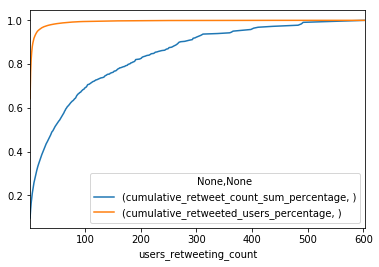

In [19]:
%matplotlib inline
retweet_grouped_by_users_retweeting_df[['cumulative_retweet_count_sum_percentage', 'cumulative_retweeted_users_percentage']].plot()

## Cut off the tail.
Removes users that were only retweeted by 5 or less users.

In [20]:
retweet_summary_df.drop(retweet_summary_df[retweet_summary_df.users_retweeting_count <= 5].index, inplace=True)
retweet_summary_df['retweet_screen_name'].count()

5374

## Approach 1: By retweet count

### Top accounts (by retweet count)
Unknown for type indicates that it is not matched with an known Twitter account.

In [21]:
retweet_summary_df.sort_values('retweet_count', ascending=False).head(50)

,retweet_count,retweet_screen_name,type,users_retweeting_count,percent_of_users_retweeting
user_id,,,,,
25073877,3655,realDonaldTrump,politicians,603,0.328431
93069110,2715,maggieNYT,journalists,492,0.267974
299802277,2508,BraddJaffy,media,489,0.266340
1917731,2398,thehill,media,403,0.219499
51241574,2085,AP,media,483,0.263072
759251,1876,CNN,media,366,0.199346
9300262,1683,politico,media,398,0.216776
14529929,1679,jaketapper,journalists,411,0.223856
2467791,1632,washingtonpost,media,437,0.238017


### Account types (by retweet count)

In [22]:
types_by_retweet_count_df = retweet_summary_df[['type', 'retweet_count']].groupby('type').sum()
types_by_retweet_count_df['type_percentage']= types_by_retweet_count_df['retweet_count'] / types_by_retweet_count_df['retweet_count'].sum()
types_by_retweet_count_df.sort_values('retweet_count', ascending=False)

,retweet_count,type_percentage
type,,
journalists,185494,0.588831
media,55239,0.175350
unknown,38893,0.123462
politicians,13312,0.042258
academic,4294,0.013631
ngo,4070,0.012920
pundit,4053,0.012866
other_political,3817,0.012117
government,2320,0.007365


## Approach 2: Per user
Retweets by type per user.

### Add type by merging screen name lookup

In [23]:
retweet_all_join_df = pd.merge(retweet_df, user_type_lookup_df[['type']], how='left', left_on='retweet_user_id', right_index=True)
retweet_all_join_df['type'].fillna('unknown', inplace=True)
# Drop tail
retweet_all_join_limited_df = retweet_all_join_df[retweet_all_join_df.retweet_user_id.isin(retweet_summary_df.index)]
retweet_all_join_limited_df.head()

,tweet_id,user_id,screen_name,retweet_user_id,retweet_screen_name,tweet_created_at,type
0,847787664963239936,285772181,akesslerdc,85131054,jeffzeleny,2017-03-31 12:28:25+00:00,journalists
1,847634105118318594,285772181,akesslerdc,128558424,erin_pelton,2017-03-31 02:18:13+00:00,unknown
3,847601029654880258,285772181,akesslerdc,58504135,shaneharris,2017-03-31 00:06:47+00:00,journalists
4,847388672785694720,285772181,akesslerdc,22772264,carolelee,2017-03-30 10:02:57+00:00,journalists
5,847200340613189633,285772181,akesslerdc,23911915,joshledermanAP,2017-03-29 21:34:36+00:00,journalists


In [24]:
retweet_summary_by_user_df = retweet_all_join_limited_df.groupby([retweet_all_join_limited_df.user_id, retweet_all_join_limited_df.type]).size().unstack().fillna(0)
# Add a total column
retweet_summary_by_user_df['total'] = retweet_summary_by_user_df.sum(axis=1)
for col_name in retweet_summary_by_user_df.columns[:-1]:
    retweet_summary_by_user_df['{}_percent'.format(col_name)] = retweet_summary_by_user_df[col_name] / retweet_summary_by_user_df.total
retweet_summary_by_user_df.head(10)

type,academic,business,cultural,foreign_political,government,journalists,media,ngo,other,other_political,...,foreign_political_percent,government_percent,journalists_percent,media_percent,ngo_percent,other_percent,other_political_percent,politicians_percent,pundit_percent,unknown_percent
user_id,,,,,,,,,,,,,,,,,,,,,
100165378,1.0,1.0,2.0,0.0,0.0,17.0,7.0,0.0,0.0,1.0,...,0.000000,0.000000,0.386364,0.159091,0.000000,0.0000,0.022727,0.068182,0.068182,0.204545
1001991865,0.0,0.0,0.0,0.0,0.0,4.0,13.0,0.0,0.0,0.0,...,0.000000,0.000000,0.235294,0.764706,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
1002229862,0.0,0.0,0.0,0.0,1.0,58.0,10.0,0.0,0.0,0.0,...,0.000000,0.012821,0.743590,0.128205,0.000000,0.0000,0.000000,0.012821,0.000000,0.102564
100802089,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.571429,0.142857,0.000000,0.0000,0.000000,0.142857,0.000000,0.142857
100860790,2.0,0.0,0.0,1.0,1.0,93.0,39.0,1.0,0.0,2.0,...,0.004717,0.004717,0.438679,0.183962,0.004717,0.0000,0.009434,0.014151,0.004717,0.325472
1009749229,4.0,0.0,0.0,0.0,6.0,133.0,14.0,10.0,4.0,0.0,...,0.000000,0.029851,0.661692,0.069652,0.049751,0.0199,0.000000,0.000000,0.019900,0.129353
1013785220,0.0,0.0,0.0,0.0,0.0,20.0,6.0,0.0,0.0,0.0,...,0.000000,0.000000,0.540541,0.162162,0.000000,0.0000,0.000000,0.108108,0.000000,0.189189
102171691,17.0,2.0,1.0,0.0,1.0,494.0,65.0,9.0,0.0,19.0,...,0.000000,0.001429,0.705714,0.092857,0.012857,0.0000,0.027143,0.021429,0.004286,0.105714
102238997,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


### Average of percent of retweets by type for each user
That is, for each user determine the percent of retweets by type. Then take the average of each type.

Thus, this retweet analysis is on a per-user basis, accounting for how prolific a tweeter a user is. (That is, users who tweet aren't weighed more heavily.)


In [25]:
retweet_summary_by_user_df.filter(axis=1, regex="_percent$").mean()

type
academic_percent             0.011965
business_percent             0.003702
cultural_percent             0.006935
foreign_political_percent    0.000697
government_percent           0.011508
journalists_percent          0.509036
media_percent                0.232894
ngo_percent                  0.013284
other_percent                0.003179
other_political_percent      0.007644
politicians_percent          0.043010
pundit_percent               0.007771
unknown_percent              0.148374
dtype: float64

## Approach 3: By count of users retweeting
The number of users that retweeted an account. Thus, each user counts as 1, even if that user made multiple retweets of the account.

This weights an account that is retweeted by a 100 users more heavily than an account that is retweeted a 100 times by a single user.

In [26]:
retweet_summary_df.sort_values('users_retweeting_count', ascending=False).head(20)

,retweet_count,retweet_screen_name,type,users_retweeting_count,percent_of_users_retweeting
user_id,,,,,
25073877,3655,realDonaldTrump,politicians,603,0.328431
93069110,2715,maggieNYT,journalists,492,0.267974
299802277,2508,BraddJaffy,media,489,0.266340
51241574,2085,AP,media,483,0.263072
2467791,1632,washingtonpost,media,437,0.238017
14529929,1679,jaketapper,journalists,411,0.223856
1917731,2398,thehill,media,403,0.219499
9300262,1683,politico,media,398,0.216776
807095,1322,nytimes,media,398,0.216776


### Account types (by count of users retweeting)

In [27]:
types_by_users_retweeting_df = retweet_summary_df[['type', 'users_retweeting_count']].groupby('type').sum()
types_by_users_retweeting_df['type_percentage']= types_by_users_retweeting_df['users_retweeting_count'] / types_by_users_retweeting_df['users_retweeting_count'].sum()
types_by_users_retweeting_df.sort_values('users_retweeting_count', ascending=False)

,users_retweeting_count,type_percentage
type,,
journalists,79291,0.559404
unknown,25236,0.178042
media,17631,0.124388
politicians,7300,0.051502
other_political,2340,0.016509
ngo,2242,0.015817
academic,2116,0.014929
pundit,1961,0.013835
government,1485,0.010477


## Unknown accounts
Remember, the tail has been cut off

### Number of unknown accounts

In [28]:
retweet_summary_df[retweet_summary_df.type == 'unknown'].count()

retweet_count                  2167
retweet_screen_name            2167
type                           2167
users_retweeting_count         2167
percent_of_users_retweeting    2167
dtype: int64

### Number of known accounts

In [29]:
retweet_summary_df[retweet_summary_df.type != 'unknown'].count()

retweet_count                  3207
retweet_screen_name            3207
type                           3207
users_retweeting_count         3207
percent_of_users_retweeting    3207
dtype: int64

### Top unknown by retweet count that are retweeted by at least 5 users

In [30]:
top_not_known_retweet_df = retweet_summary_df[(retweet_summary_df.type == 'unknown') & (retweet_summary_df.users_retweeting_count >= 5)].sort_values('retweet_count', ascending=False)[['retweet_screen_name', 'retweet_count', 'users_retweeting_count']]
top_not_known_retweet_df.head(50)

,retweet_screen_name,retweet_count,users_retweeting_count
user_id,,,
26574283,CNBCnow,210,85
18028893,JesseRodriguez,195,104
36397873,FoxNewsResearch,190,13
327484803,WSJCentralBanks,189,9
2316383071,RVAwonk,166,60
39279821,brianklaas,162,75
3066084185,APBusiness,158,29
738767160395321345,ChadBown,151,12
15110357,ReutersBiz,118,38


### Write top accounts to file

In [31]:
top_not_known_retweet_df.to_csv('unknown_retweets.csv')